In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import torch
import random
import torch.nn as nn
import sklearn
import collections
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import json
from torch.optim import Adam
import pylab
from scipy.optimize import curve_fit
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Penn/Colab/Data/')
from func import load_model, save_model

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Load Background data, which will be used for training
filename = 'BKG_dataset.h5'
with h5py.File('/content/gdrive/MyDrive/Penn/Colab/Data/BKG_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)

(640000, 57)


In [3]:
# Dataset object to allow for batch training
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return [torch.from_numpy(self.X[index]), torch.from_numpy(self.y[index])]

    def collate_fn(self, batch):
        X = [torch.tensor(sample[0]).float() for sample in batch]
        y = [torch.tensor(sample[1]).float() for sample in batch]
        return torch.stack(X, 0), torch.stack(y, 0)

    def create_dataloader(self, batch_size, shuffle=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle)

In [4]:
# Define consts
LEARNING_RATE = 1e-3
PATIENCE = 5
NUM_EPOCHS = 10
BATCH_SIZE = 1024

In [5]:
# Initialize datasets
train_dataset = Dataset(X=X_train, y=X_train)
test_dataset = Dataset(X=X_test, y=X_test)
val_dataset = Dataset(X=X_val, y=X_val)
# print ("Datasets:\n"
#     f"  Train dataset:{train_dataset.__str__()}\n"
#     f"  Val dataset: {val_dataset.__str__()}\n"
#     f"  Test dataset: {test_dataset.__str__()}\n"
#     "Sample point:\n"
#     f"  X: {train_dataset[0][0]}\n"
#     f"  y: {train_dataset[0][1]}")

In [6]:
# Initialize dataloaders
train_loader = train_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=True)
test_loader = test_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
val_loader = val_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
batch_X, batch_y = next(iter(train_loader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n")
#     "Sample point:\n"
#     f"  X: {batch_X[0]}\n"
#     f"  y: {batch_y[0]}")

Sample batch:
  X: [1024, 57]
  y: [1024, 57]



<ipython-input-3-1cc7e110d093>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-3-1cc7e110d093>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


In [7]:
class DNN_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        """input_dim: dimension of the input data.
        latent_dim: dimension of the latent space. Should be smaller than all of the other layers.
        num_nodes: two element array containing the number of nodes in the two hidden layers."""
        super(DNN_AE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x_in):
        """Forward through the autoencoder with relu activation."""

        # Encoder
        z = F.relu(self.fc1(x_in))
        z = F.relu(self.fc2(z))

        # Decoder
        z = F.relu(self.fc3(z))
        z = self.fc4(z)
        return z

In [8]:
# Define a class which will handle training and testing the model
class Trainer(object):
    def __init__(self, model, num_batches_avg, loss_fn=None, optimizer=None, scheduler=None):
        """num_batches_avg: Number of batches to calculate the average loss over.
        example: if there are 625 batches, we might want to use 25, to calculate
        average loss over 25 batches."""

        #Set params
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_batches_avg = num_batches_avg

    def train_step(self, dataloader):
        """Train for one epoch.

        returns: average loss over most recent {num_batches_avg} batches, loss over most recent batch
        """

        self.model.train()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0

        # Iterate over batches in dataloader
        for i, batch in enumerate(dataloader):

            # Pass a single batch through the model and update the weights
            inputs, targets = batch
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)
            loss.backward()
            self.optimizer.step()

            # Update loss metrics
            running_loss += loss.item()
            current_loss = loss.item()

            # Calculate the average loss
            if i % self.num_batches_avg == self.num_batches_avg - 1:
                avg_loss = running_loss / self.num_batches_avg
                running_loss = 0.0

        return avg_loss, current_loss

    def eval_step(self, dataloader):
        """validation or test step over one epoch."""

        self.model.eval()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0
        y_trues, model_outputs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, y_true = batch
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, y_true)

                # Update loss metrics
                running_loss += loss.item()
                current_loss = loss.item()

                # Calculate the average loss
                if i % self.num_batches_avg == self.num_batches_avg - 1:
                    avg_loss = running_loss / self.num_batches_avg
                    running_loss = 0.0

                # Store outputs
                y_trues.extend(y_true)
                model_outputs.extend(outputs)
        return avg_loss, current_loss, np.vstack(y_trues), np.vstack(model_outputs)

    def predict_step(self, dataloader):
        """Prediction step."""
        self.model.eval()
        model_outputs = []

        # Iterate over batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, targets = batch
                outputs = self.model(inputs)

                # Store outputs
                model_outputs.extend(outputs)

        return np.vstack(model_outputs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        """Train the neural net."""

        best_val_loss = np.inf

        # Loop over epochs
        for epoch in range(num_epochs):

            # Steps
            avg_train_loss, last_train_loss = self.train_step(dataloader=train_dataloader)
            avg_val_loss, last_val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = self.model
                patience_counter = patience # reset patience
            else:
                patience_counter -= 1
            if not patience: # 0
                print("Stoping Early!")
                break

            # Logging
            print(f'Epoch: {epoch+1} | '
            f'average train loss over most recent {self.num_batches_avg} batches: {avg_train_loss},'
            f'average val loss over most recent {self.num_batches_avg} batches: {avg_val_loss},'
            #f'learning rate: {self.optimizer.param_groups[0]['lr']:.2E},'
            f'patience counter: {patience_counter}')

        return best_model

In [9]:
# Initialize model
INPUT_DIM = X_train.shape[1]
HIDDEN_DIM = 16
LATENT_DIM = 3
dense_AE = DNN_AE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
print(dense_AE.named_parameters)

<bound method Module.named_parameters of DNN_AE(
  (fc1): Linear(in_features=57, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=57, bias=True)
)>


In [10]:
# Initialize the loss function, optimizer and lr scheduler
loss_fn = nn.MSELoss()
optimizer = Adam(params=dense_AE.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=3, verbose=True)

In [11]:
# Initialize trainer
trainer = Trainer(model=dense_AE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [12]:
# Train

best_model = trainer.train(
    num_epochs=NUM_EPOCHS, patience=PATIENCE,
    train_dataloader=train_loader, val_dataloader=val_loader)

<ipython-input-3-1cc7e110d093>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-3-1cc7e110d093>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


Epoch: 1 | average train loss over most recent 25 batches: 4.697761650085449,average val loss over most recent 25 batches: 4.825384244918824,patience counter: 5
Epoch: 2 | average train loss over most recent 25 batches: 2.6481240797042847,average val loss over most recent 25 batches: 2.6111906480789187,patience counter: 5
Epoch: 3 | average train loss over most recent 25 batches: 2.408762564659119,average val loss over most recent 25 batches: 2.367156772613525,patience counter: 5
Epoch: 4 | average train loss over most recent 25 batches: 2.391344122886658,average val loss over most recent 25 batches: 2.3717916774749757,patience counter: 4
Epoch: 5 | average train loss over most recent 25 batches: 2.1955280685424805,average val loss over most recent 25 batches: 2.3655107164382936,patience counter: 5
Epoch: 6 | average train loss over most recent 25 batches: 2.346483883857727,average val loss over most recent 25 batches: 2.374827437400818,patience counter: 4
Epoch: 7 | average train loss

In [13]:
# Save model
torch.save(best_model.state_dict(), '/content/gdrive/MyDrive/Penn/Colab/Trained_Models/DNN_AE.pt')

In [15]:
dense_AE = DNN_AE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dense_AE.load_state_dict(torch.load('/content/gdrive/MyDrive/Penn/Colab/Trained_Models/DNN_AE.pt'))
dense_AE.eval()

DNN_AE(
  (fc1): Linear(in_features=57, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=57, bias=True)
)

In [16]:
bkg_prediction = trainer.predict_step(dataloader=test_loader)

<ipython-input-3-1cc7e110d093>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-3-1cc7e110d093>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


In [17]:
# add correct signal labels
signal_labels = ['Ato4l']

In [18]:
# add correct path to signal files
signals_file = ['/content/gdrive/MyDrive/Penn/Colab/Data/Ato4l_lepFilter_13TeV_dataset.h5']

In [21]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(test_data)

print(np.array(signal_data).shape)

signal_dataset = Dataset(X=signal_data, y=signal_data)
signal_loader = signal_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
batch_X, batch_y = next(iter(signal_loader))

print(len(signal_loader))

(1, 55969, 57)
1


<ipython-input-3-1cc7e110d093>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-3-1cc7e110d093>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


In [22]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = trainer.predict_step(dataloader=signal_loader)
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal


<ipython-input-3-1cc7e110d093>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-3-1cc7e110d093>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


In [23]:
save_file = 'dnnae_results'

In [24]:
with h5py.File('/content/gdrive/MyDrive/Penn/Colab/Data/'+save_file, 'w') as file:
    file.create_dataset('BKG_input', data=X_test)
    file.create_dataset('BKG_predicted', data = bkg_prediction)
    for i, sig in enumerate(signal_results):
        file.create_dataset('%s_input' %sig[0], data=sig[1])
        file.create_dataset('%s_predicted' %sig[0], data=sig[2])

In [25]:
from func import mse_loss

In [27]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test,
                           bkg_prediction.astype(np.float32)).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X,
                               signal_results[i][2].astype(np.float32)).numpy())

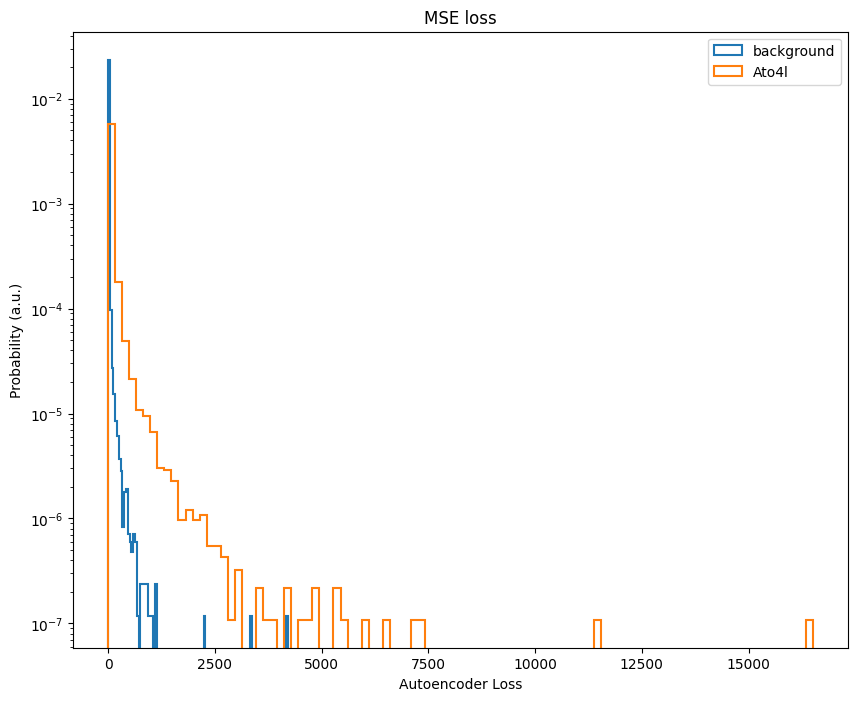

In [28]:
bin_size=100

plt.figure(figsize=(10,8))
# for i, label in enumerate(signal_labels):
#     plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

plt.hist(total_loss[0], bins=bin_size, label='background', density = True, histtype='step', fill=False, linewidth=1.5)
plt.hist(total_loss[1], bins=bin_size, label='Ato4l', density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

In [29]:
from sklearn.metrics import roc_curve, auc

In [30]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

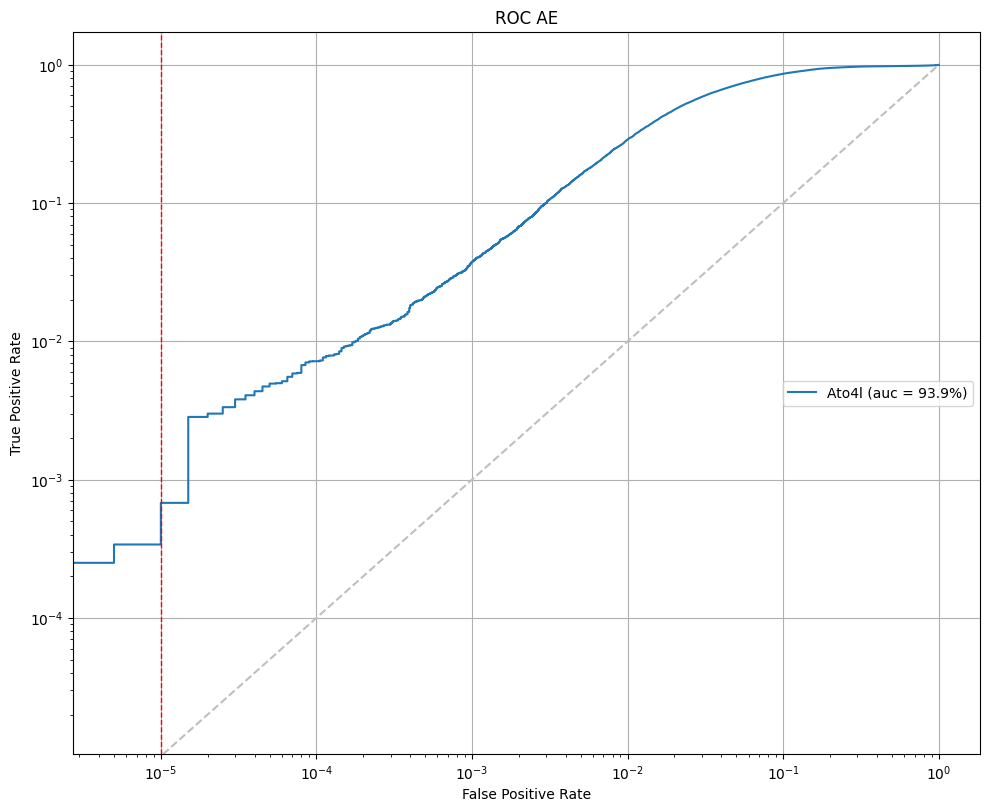

In [31]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()